In [52]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from pyscf.grad import RHF as g
from numpy.linalg import norm

In [19]:
import inspect
import sys
sys.path.append("../Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [20]:
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [97]:
def pcX(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("sto-3g",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=pcX(ref)
        rbm=pcX(ref-1)
        rbp=pcX(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  # ref+a(z-zr) +b(z-zr)^2
            a=(rbp[i][1][0]-rbm[i][1][0])/2
            b=(rbp[i][1][0]+rbm[i][1][0]-2*rb[i][1][0])
            fb[i][1][0]+=a*(z-ref)+b*(z-ref)**2

        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

The formula for the gradient is stated in Pople's article (Eq.21) as: 
$$ \frac{\partial E}{\partial Z}= \sum_{\mu\nu}P_{\mu\nu}\frac{\partial H_{\mu\nu}}{\partial Z}+\frac{1}{2}\sum_{\mu\nu\lambda\sigma}
P_{\mu\nu}P_{\lambda\sigma}\frac{\partial}{\partial Z}(\mu \lambda | | \nu\sigma)+\frac{\partial V_{nuc}}{\partial Z} 
-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial Z}
$$
$W$ is an energy weighted density matrix:
$$ W_{\mu\nu}= \sum_i ^{mo.occ.} \epsilon_i c_{\mu i} c_{\nu i}^\dagger
$$

In [80]:
nn=gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]))
mf=scf.RHF(nn)
e_nn=mf.scf()

converged SCF energy = -107.491645836044


In [81]:
S=mf.get_ovlp()
h1=mf.get_hcore()
P=mf.make_rdm1()
C=mf.mo_coeff
O=mf.mo_occ
e=mf.mo_energy
nn.ao_labels()

['0 N 1s    ',
 '0 N 2s    ',
 '0 N 2px   ',
 '0 N 2py   ',
 '0 N 2pz   ',
 '1 N 1s    ',
 '1 N 2s    ',
 '1 N 2px   ',
 '1 N 2py   ',
 '1 N 2pz   ']

In [82]:
g_ijkl=nn.intor("int2e_sph")

In [83]:
cn=gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]),charge=-1)
on=gto.M(atom="O 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]),charge=1)

In [84]:
mf_on=scf.RHF(on)
mf_cn=scf.RHF(cn)
e_on=mf_on.scf()
e_cn=mf_cn.scf()

converged SCF energy = -127.196060151265
converged SCF energy = -90.9175998689459


In [132]:
S_T=mf_on.get_ovlp()
dS=(mf_on.get_ovlp()-mf.get_ovlp())
dh1=(mf_on.get_hcore()-mf.get_hcore())
dG=(on.intor("int2e_sph")-nn.intor("int2e_sph"))
dVnn=(8*7-7*7)/2.05

In [133]:
def E_cn(l):
    mol_l=FcM(fcs=[l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7+l,ref=7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e
def P_cn(l):
    mol_l=FcM(fcs=[l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7+l,ref=7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    p=mf_l.make_rdm1()
    return p

For the second alchemical derivative we need at first the response matrix

In [134]:
#The old code for nbs derivs
def alchemy_pol_deriv(polobj,dL, with_cphf=True):
    mf = polobj._scf
    mol = mf.mol
    mo_energy = mf.mo_energy
    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    occidx = mo_occ > 0
    orbo = mo_coeff[:, occidx]
    orbv = mo_coeff[:,~occidx]

    charges = mol.atom_charges()
    coords  = mol.atom_coords()
    charge_center = np.einsum('i,ix->x', charges, coords) / charges.sum()
    
    int_r=DeltaV(mol,dL)    ########   .001 as finite difference intervall  
    h1 = lib.einsum('xpq,pi,qj->xij', int_r, mo_coeff.conj(), orbo) #going to molecular orbitals?
    s1 = np.zeros_like(h1)
    vind = polobj.gen_vind(mf, mo_coeff, mo_occ)
    if with_cphf:
        mo1,e1 = cphf.solve(vind, mo_energy, mo_occ, h1, s1, polobj.max_cycle_cphf, polobj.conv_tol)
    else:
        mo1 = rhf_nmr._solve_mo1_uncoupled(mo_energy, mo_occ, h1, s1)[0]
    return mo1,e1[0]

In [143]:
#attempt to o this for luck
from pyscf.scf import cphf
vind = gen_vind(mf, C,  mf.mo_occ)
#dh1_mo=(C.T@dh1@C)[:,:7]
mo_coeff = mf.mo_coeff
mo_occ = mf.mo_occ
occidx = mo_occ > 0
orbo = mo_coeff[:, occidx]
dh1_mo= np.einsum('pq,pi,qj->ij', dh1, C.T, orbo) #going to molecular orbitals
dS_mo=np.einsum('pq,pi,qj->ij', dS, C.T, orbo)
dS_mo=np.zeros_like(dh1_mo)
mo1,e1 = cphf.solve(vind, e,  mf.mo_occ,dh1_mo, dS_mo, 20 ,1e-5)
nao=nn.nao
nocc=nn.nelec[0]
mo1=np.einsum('pq,qi->pi', mo_coeff, mo1).reshape(nao,nocc)

In [138]:
def make_dP(mf,mo1):
    mol=mf.mol
    nao=mol.nao
    nocc=mf.mol.nelec[0]
    C=mf.mo_coeff
    dP=np.zeros_like(C)
    dP[:,:]=np.einsum('ij,jk,lk->il',C,mo1,C[:,:nocc])
    return dP+dP.T

(array([-9.28946011e-02,  1.92298355e+00, -1.54055382e-03,  2.32267239e-01,
        -5.62857440e-01,  2.84139526e-02,  6.17571267e-01,  2.61938017e-05,
         2.30700492e-01, -1.23338314e+00]),
 array([-7.42004467, -2.01708233, -1.61650771, -1.61650771, -1.47911251,
        -0.48780488, -0.48061857, -0.44273505, -0.44273505, -0.55544402]))

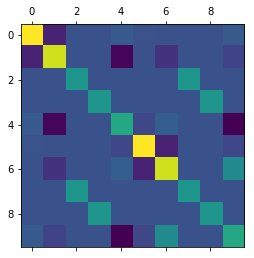

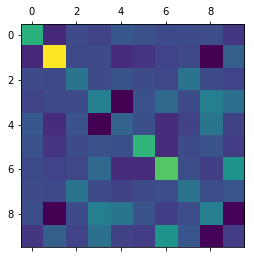

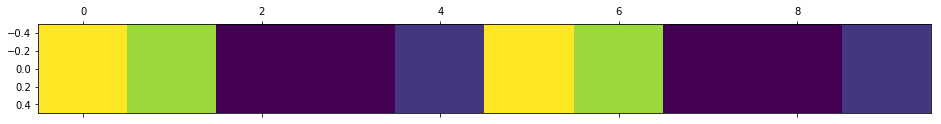

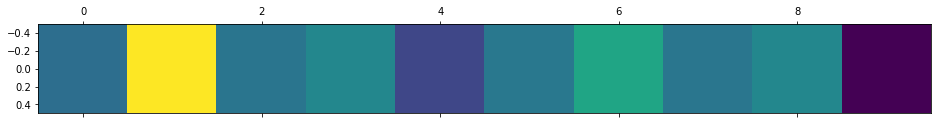

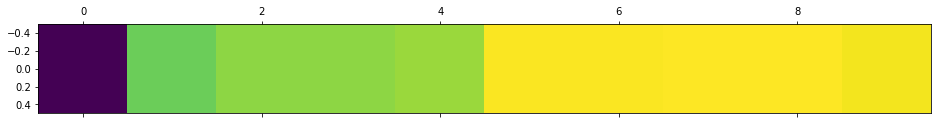

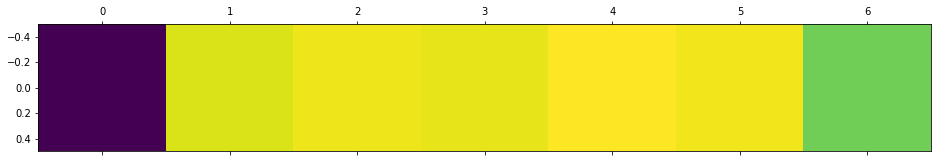

In [159]:
dP=make_dP(mf,mo1)
plt.matshow(P)
plt.matshow((P+dP))
plt.matshow([P.diagonal()])
plt.matshow([dP.diagonal()])
plt.matshow([dh1.diagonal()])
plt.matshow([dh1_mo.diagonal()])

dP.diagonal(),dh1.diagonal()

In [141]:
nao=nn.nao
nocc=nn.nelec[0]
U=np.zeros((nao,nao))
U[:,:nocc]=mo1[:,:nocc]
U=U-U.T
O=np.diag(mf.mo_occ)
C=mf.mo_coeff
dP=C@(U@O-O@U)@C.T

In [145]:
norm(P),norm(dP)

(5.167107809446375, 4.594798756144595)

In [155]:
norm(P_cn(-1)-(P+dP)),norm(P_cn(-1)-(P)),norm(P_cn(-1)+(dP))

(4.793141161091937, 0.5801656711188032, 7.248181911761305)

In [150]:
np.einsum("ij,ij",P+dP,S+dS)

13.912396811577844

In [152]:
norm(P_cn(-1)-(dP))

6.490047466109698

In [ ]:
# FOR HESSIAN CALCULATIONS 
# if mo1 is None or mo_e1 is None:
#         mo1, mo_e1 = hessobj.solve_mo1(mo_energy, mo_coeff, mo_occ, h1ao,
#                                        None, atmlst, max_memory, log)
"""
def solve_mo1(mf, mo_energy, mo_coeff, mo_occ, h1ao_or_chkfile,
              fx=None, atmlst=None, max_memory=4000, verbose=None):
    '''Solve the first order equation

    Kwargs:
        fx : function(dm_mo) => v1_mo
            A function to generate the induced potential.
            See also the function gen_vind.
    '''
    mol = mf.mol
    if atmlst is None: atmlst = range(mol.natm)

    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:,mo_occ>0]
    nocc = mocc.shape[1]

    if fx is None:
        fx = gen_vind(mf, mo_coeff, mo_occ)
    s1a = -mol.intor('int1e_ipovlp', comp=3)

    def _ao2mo(mat):
        return numpy.asarray([reduce(numpy.dot, (mo_coeff.T, x, mocc)) for x in mat])

    mem_now = lib.current_memory()[0]
    max_memory = max(2000, max_memory*.9-mem_now)
    blksize = max(2, int(max_memory*1e6/8 / (nmo*nocc*3*6)))
    mo1s = [None] * mol.natm
    e1s = [None] * mol.natm
    aoslices = mol.aoslice_by_atom()
    for ia0, ia1 in lib.prange(0, len(atmlst), blksize):
        s1vo = []
        h1vo = []
        for i0 in range(ia0, ia1):
            ia = atmlst[i0]
            shl0, shl1, p0, p1 = aoslices[ia]
            s1ao = numpy.zeros((3,nao,nao))
            s1ao[:,p0:p1] += s1a[:,p0:p1]
            s1ao[:,:,p0:p1] += s1a[:,p0:p1].transpose(0,2,1)
            s1vo.append(_ao2mo(s1ao))
            if isinstance(h1ao_or_chkfile, str):
                key = 'scf_f1ao/%d' % ia
                h1ao = lib.chkfile.load(h1ao_or_chkfile, key)
            else:
                h1ao = h1ao_or_chkfile[ia]
            h1vo.append(_ao2mo(h1ao))

        h1vo = numpy.vstack(h1vo)
        s1vo = numpy.vstack(s1vo)
        mo1, e1 = cphf.solve(fx, mo_energy, mo_occ, h1vo, s1vo)
        mo1 = numpy.einsum('pq,xqi->xpi', mo_coeff, mo1).reshape(-1,3,nao,nocc)
        e1 = e1.reshape(-1,3,nocc,nocc)

        for k in range(ia1-ia0):
            ia = atmlst[k+ia0]
            if isinstance(h1ao_or_chkfile, str):
                key = 'scf_mo1/%d' % ia
                lib.chkfile.save(h1ao_or_chkfile, key, mo1[k])
            else:
                mo1s[ia] = mo1[k]
            e1s[ia] = e1[k].reshape(3,nocc,nocc)
        mo1 = e1 = None
    return mo1s, e1s

"""
pass

In [32]:
from functools import reduce
import ctypes
import time
import numpy
from pyscf import lib
from pyscf import gto
from pyscf.lib import logger
from pyscf.scf import _vhf
def gen_vind(mf, mo_coeff, mo_occ):
    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:,mo_occ>0]
    nocc = mocc.shape[1]
    vresp = mf.gen_response(mo_coeff, mo_occ, hermi=1)
    def fx(mo1):
        mo1 = mo1.reshape(-1,nmo,nocc)
        nset = len(mo1)
        dm1 = numpy.empty((nset,nao,nao))
        for i, x in enumerate(mo1):
            dm = reduce(numpy.dot, (mo_coeff, x*2, mocc.T)) # *2 for double occupancy
            dm1[i] = dm + dm.T
        v1 = vresp(dm1)
        v1vo = numpy.empty_like(mo1)
        for i, x in enumerate(v1):
            v1vo[i] = reduce(numpy.dot, (mo_coeff.T, x, mocc))
        return v1vo
    return fx


In [ ]:
vind=gen_vind(mf,C,O)